# Multiplication

This example will show you how to multiply two values.
The model architecture can be thought of as
a combination of the combining demo and the squaring demo.
Essentially, we project both inputs independently into a 2D space,
and then decode a nonlinear transformation of that space
(the product of the first and second vector elements).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.dists import Choice
from nengo.processes import Piecewise

## Step 1: Create the model

The model has four ensembles:
two input ensembles ('A' and 'B'),
a 2D combined ensemble ('Combined'),
and an output ensemble ('D').

In [2]:
# Create the model object
model = nengo.Network(label='Multiplication')
with model:
    # Create 4 ensembles of leaky integrate-and-fire neurons
    A = nengo.Ensemble(100, dimensions=1, radius=10)
    B = nengo.Ensemble(100, dimensions=1, radius=10)
    combined = nengo.Ensemble(
        220, dimensions=2, radius=15)  # This radius is ~sqrt(10^2+10^2)
    prod = nengo.Ensemble(100, dimensions=1, radius=20)

# This next two lines make all of the encoders in the Combined population
# point at the corners of the cube.
# This improves the quality of the computation.

# Comment out the line below for 'normal' encoders
combined.encoders = Choice([[1, 1], [-1, 1], [1, -1], [-1, -1]])

## Step 2: Provide input to the model

We will use two varying scalar values for the two input signals
that drive activity in ensembles A and B.

In [3]:
with model:
    # Create a piecewise step function for input
    inputA = nengo.Node(Piecewise({0: 0, 2.5: 10, 4: -10}))
    inputB = nengo.Node(Piecewise({0: 10, 1.5: 2, 3: 0, 4.5: 2}))

    correct_ans = Piecewise({0: 0, 1.5: 0, 2.5: 20, 3: 0, 4: 0, 4.5: -20})

## Step 3: Connect the elements of the model

In [4]:
with model:
    # Connect the input nodes to the appropriate ensembles
    nengo.Connection(inputA, A)
    nengo.Connection(inputB, B)

    # Connect input ensembles A and B to the 2D combined ensemble
    nengo.Connection(A, combined[0])
    nengo.Connection(B, combined[1])

    # Define a function that computes the multiplication of two inputs
    def product(x):
        return x[0] * x[1]

    # Connect the combined ensemble to the output ensemble D
    nengo.Connection(combined, prod, function=product)

## Step 4: Probe the output

Collect output data from each ensemble and input.

In [5]:
with model:
    inputA_probe = nengo.Probe(inputA)
    inputB_probe = nengo.Probe(inputB)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    combined_probe = nengo.Probe(combined, synapse=0.01)
    prod_probe = nengo.Probe(prod, synapse=0.01)

## Step 5: Run the model

In [6]:
# Create the simulator
with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
    sim.run(5)

## Step 6: Plot the results

To check the performance of the model,
we can plot the input signals and decoded ensemble values.

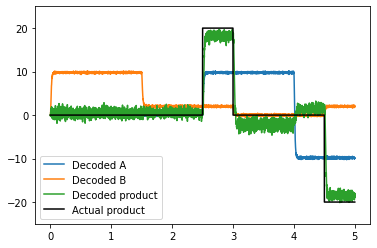

In [7]:
# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(
    sim.trange(), sim.data[A_probe], label="Decoded A")
plt.plot(
    sim.trange(), sim.data[B_probe], label="Decoded B")
plt.plot(
    sim.trange(), sim.data[prod_probe], label="Decoded product")
plt.plot(
    sim.trange(), correct_ans.run(sim.time, dt=sim.dt),
    c='k', label="Actual product")
plt.legend(loc='best')
plt.ylim(-25, 25);

The input signals we chose make it obvious when things are working,
as the inputs are zero often (so the product should be).
When choosing encoders randomly around the circle (the default in Nengo),
you may see more unwanted interactions between the inputs.
To see this, comment the above code that sets the encoders
to the corners of the cube (in Step 1 where it says
`# Comment out the line below for 'normal' encoders`).

## Bonus step: Make a subnetwork

If you find that you need to compute the product
in several parts of your network,
you can put all of the components necessary
to compute the product
together in a subnetwork.
By making a function to construct this subnetwork,
it becomes easy to make many such networks
in a single model.

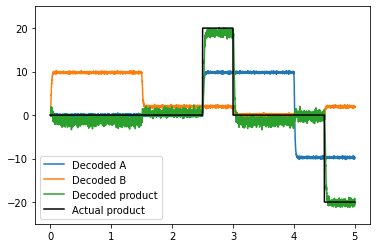

In [8]:
def Product(neuron_per_dimension, input_magnitude):
    # Create the model object
    model = nengo.Network(label='Product')
    with model:
        # Create passthrough nodes to redirect both inputs
        model.A = nengo.Node(output=None, size_in=1)
        model.B = nengo.Node(output=None, size_in=1)

        model.combined = nengo.Ensemble(
            neuron_per_dimension * 2,
            dimensions=2,
            radius=np.sqrt(input_magnitude**2 + input_magnitude**2),
            encoders=Choice([[1, 1], [-1, 1], [1, -1], [-1, -1]]))

        model.prod = nengo.Ensemble(
            neuron_per_dimension, dimensions=1, radius=input_magnitude * 2)

        # Connect everything up
        nengo.Connection(model.A, model.combined[0], synapse=None)
        nengo.Connection(model.B, model.combined[1], synapse=None)

        def product(x):
            return x[0] * x[1]

        nengo.Connection(model.combined, model.prod, function=product)
    return model


# The previous model can then be replicated with the following
model = nengo.Network(label='Multiplication')
with model:
    inputA = nengo.Node(Piecewise({0: 0, 2.5: 10, 4: -10}))
    inputB = nengo.Node(Piecewise({0: 10, 1.5: 2, 3: 0, 4.5: 2}))
    A = nengo.Ensemble(100, dimensions=1, radius=10)
    B = nengo.Ensemble(100, dimensions=1, radius=10)
    prod = Product(100, input_magnitude=10)
    nengo.Connection(inputA, A)
    nengo.Connection(inputB, B)
    nengo.Connection(A, prod.A)
    nengo.Connection(B, prod.B)

    inputA_probe = nengo.Probe(inputA)
    inputB_probe = nengo.Probe(inputB)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    combined_probe = nengo.Probe(prod.combined, synapse=0.01)
    prod_probe = nengo.Probe(prod.prod, synapse=0.01)

# Create the simulator
with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
    sim.run(5)

# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(
    sim.trange(), sim.data[A_probe], label="Decoded A")
plt.plot(
    sim.trange(), sim.data[B_probe], label="Decoded B")
plt.plot(
    sim.trange(), sim.data[prod_probe], label="Decoded product")
plt.plot(
    sim.trange(), correct_ans.run(sim.time, dt=sim.dt),
    c='k', label="Actual product")
plt.legend(loc='best')
plt.ylim(-25, 25);

Alternatively, you can use Nengo's built in
[`nengo.networks.Product` network](
https://www.nengo.ai/nengo/networks.html#nengo.networks.Product).
This network works with input of any dimensionality
(e.g., to compute the dot product of two large vectors)
and uses special optimizatons to make the product
more accurate than this implementation.